In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = "drive/MyDrive/645-project-data/"

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display, Image
import os
import pathlib
import glob
import shutil
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from keras.models import load_model
from skimage.transform import resize

In [ ]:
labels = pd.read_csv(path + "labels.csv")
labels["id"] = [fname + ".jpg" for fname in labels["id"]]
labels_test = pd.read_csv(path + "test-labels.csv")

le = LabelEncoder()
labels["breeds_encoded"] = le.fit_transform(labels['breed'])
breed_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


# Grad-CAM Analysis v1

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # grad_model = tf.keras.models.Model(
    #     [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    # )
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]

    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]
        

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(256, 256))
    return heatmap_resized

In [ ]:
image_name = "x4.jpg"
image_path = path + "test_2/" + image_name
image_size = (224,224)
layer_name = "conv4_block3_2_conv"

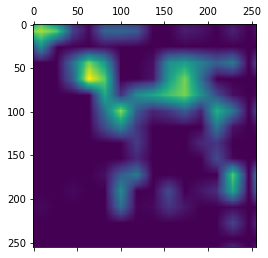

In [ ]:
# Prepare image
preprocess_input = keras.applications.resnet50.preprocess_input
img_array = preprocess_input(get_img_array(image_path, size=image_size))

model_all = load_model(path + 'models/' + 'dog_breed_classifier_resnet50_95T79V.h5')
model = model_all.get_layer('resnet50')

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

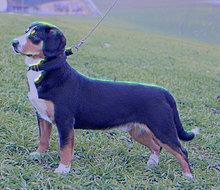

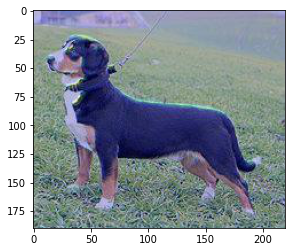

In [ ]:
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    plt.imshow(plt.imread(cam_path))
    

save_and_display_gradcam(image_path, heatmap)

In [ ]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]

conv5_block3_3_conv


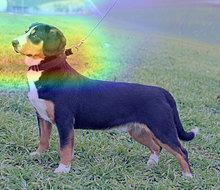

conv5_block3_2_conv


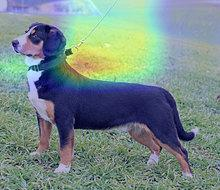

conv5_block3_1_conv


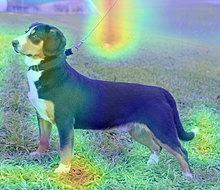

conv5_block2_3_conv


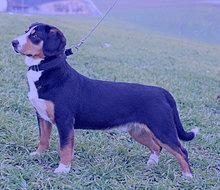

conv5_block2_2_conv


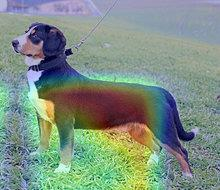

conv5_block2_1_conv


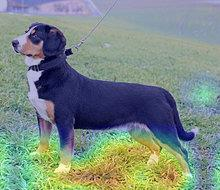

conv5_block1_3_conv


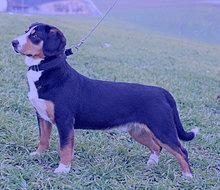

conv5_block1_0_conv


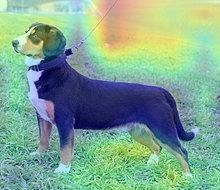

conv5_block1_2_conv


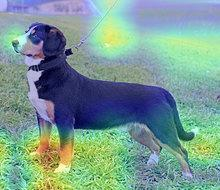

conv5_block1_1_conv


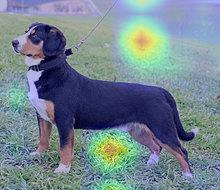

conv4_block6_3_conv


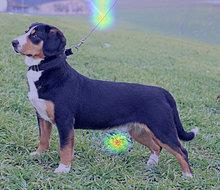

conv4_block6_2_conv


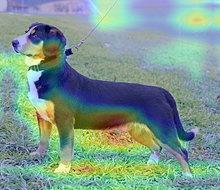

conv4_block6_1_conv


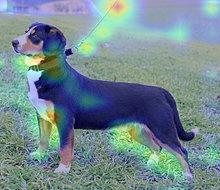

conv4_block5_3_conv


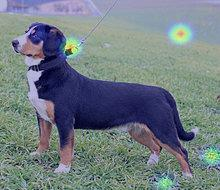

conv4_block5_2_conv


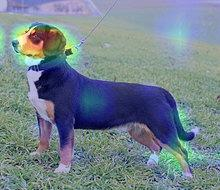

conv4_block5_1_conv


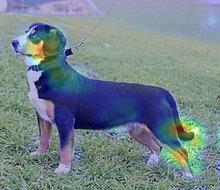

conv4_block4_3_conv


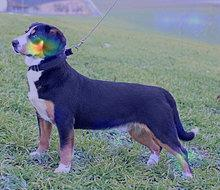

conv4_block4_2_conv


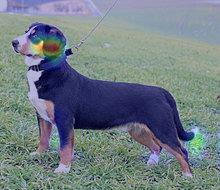

conv4_block4_1_conv


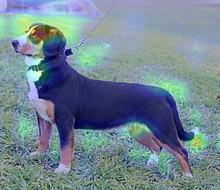

conv4_block3_3_conv


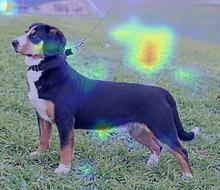

conv4_block3_2_conv


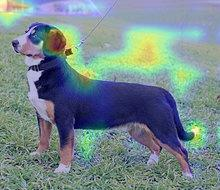

conv4_block3_1_conv


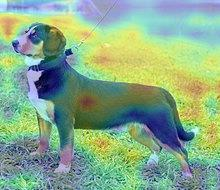

conv4_block2_3_conv


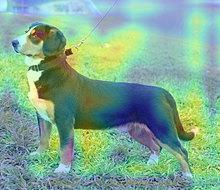

conv4_block2_2_conv


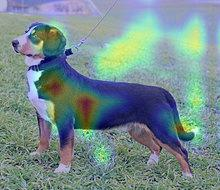

conv4_block2_1_conv


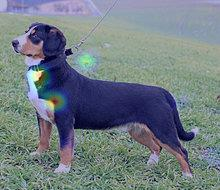

conv4_block1_3_conv


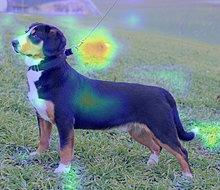

conv4_block1_0_conv


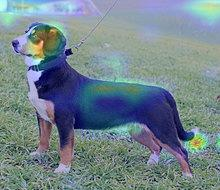

conv4_block1_2_conv


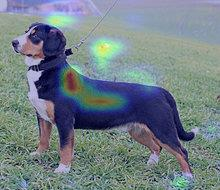

conv4_block1_1_conv


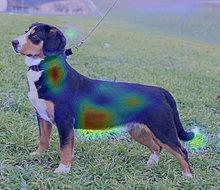

conv3_block4_3_conv


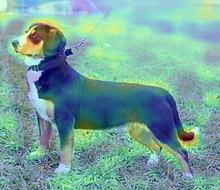

conv3_block4_2_conv


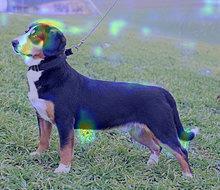

conv3_block4_1_conv


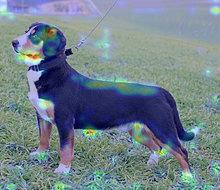

conv3_block3_3_conv


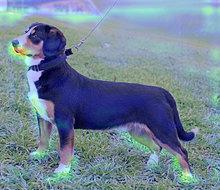

conv3_block3_2_conv


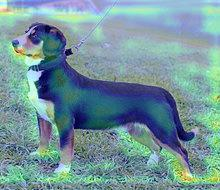

conv3_block3_1_conv


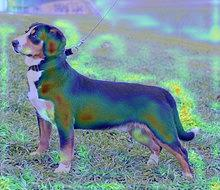

conv3_block2_3_conv


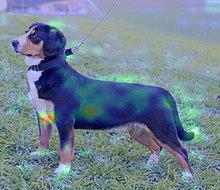

conv3_block2_2_conv


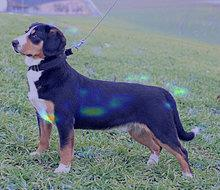

conv3_block2_1_conv


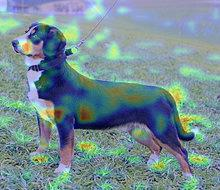

conv3_block1_3_conv


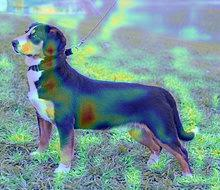

conv3_block1_0_conv


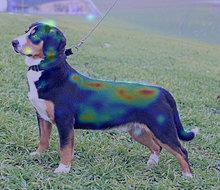

conv3_block1_2_conv


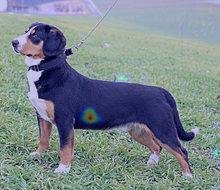

conv3_block1_1_conv


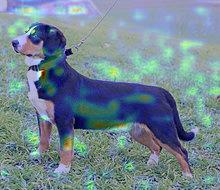

conv2_block3_3_conv


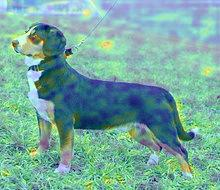

conv2_block3_2_conv


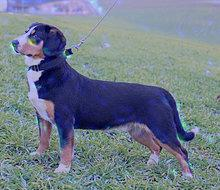

conv2_block3_1_conv


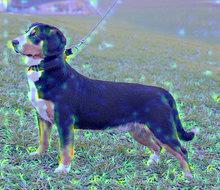

conv2_block2_3_conv


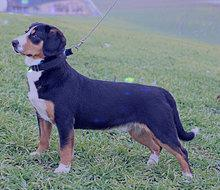

conv2_block2_2_conv


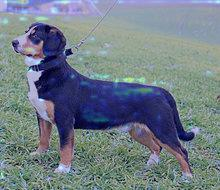

conv2_block2_1_conv


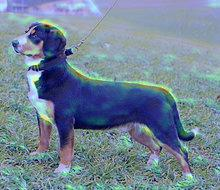

conv2_block1_3_conv


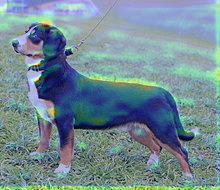

conv2_block1_0_conv


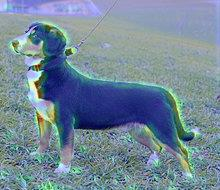

conv2_block1_2_conv


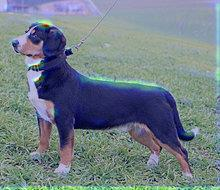

conv2_block1_1_conv


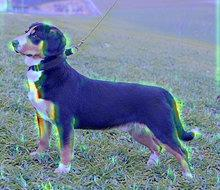

conv1_conv


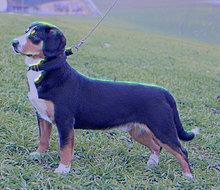

In [ ]:
for layer in conv2D_layers:
    heatmap = make_gradcam_heatmap(img_array, model, layer)
    print(layer)
    save_and_display_gradcam(image_path, heatmap)

# Grad-CAM Analysis v2

In [ ]:
from tensorflow.keras.models import Model
import cv2



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [ ]:
image_name = "x4.jpg"
layer_name = "conv5_block3_3_conv"
image_path = path + "test_2/" + image_name
image_size = (224,224)
preprocess_input = keras.applications.resnet50.preprocess_input
img_array = preprocess_input(get_img_array(image_path, size=image_size))

model_all = load_model(path + 'models/' + 'dog_breed_classifier_resnet50_95T79V.h5')
model = model_all.get_layer('resnet50')


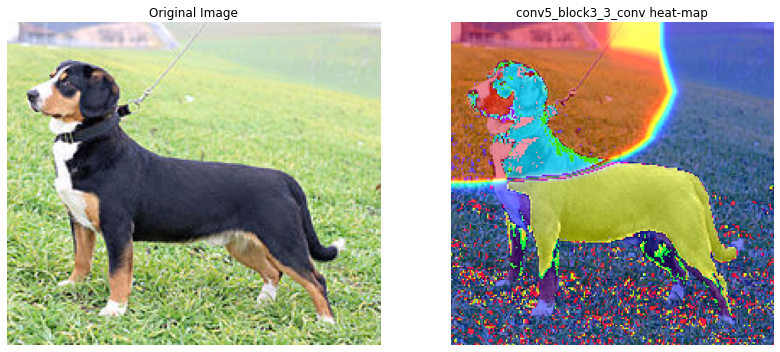

In [ ]:
img = img_array[0]
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(plt.imread(path + "test_2/" + image_name))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(f'{layer_name} heat-map')
plt.tight_layout()

In [ ]:
conv2D_layers = [layer.name for layer in model.layers if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in model.layers if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'Activation']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'Activation' or isinstance(layer, tf.keras.layers.Conv2D))]

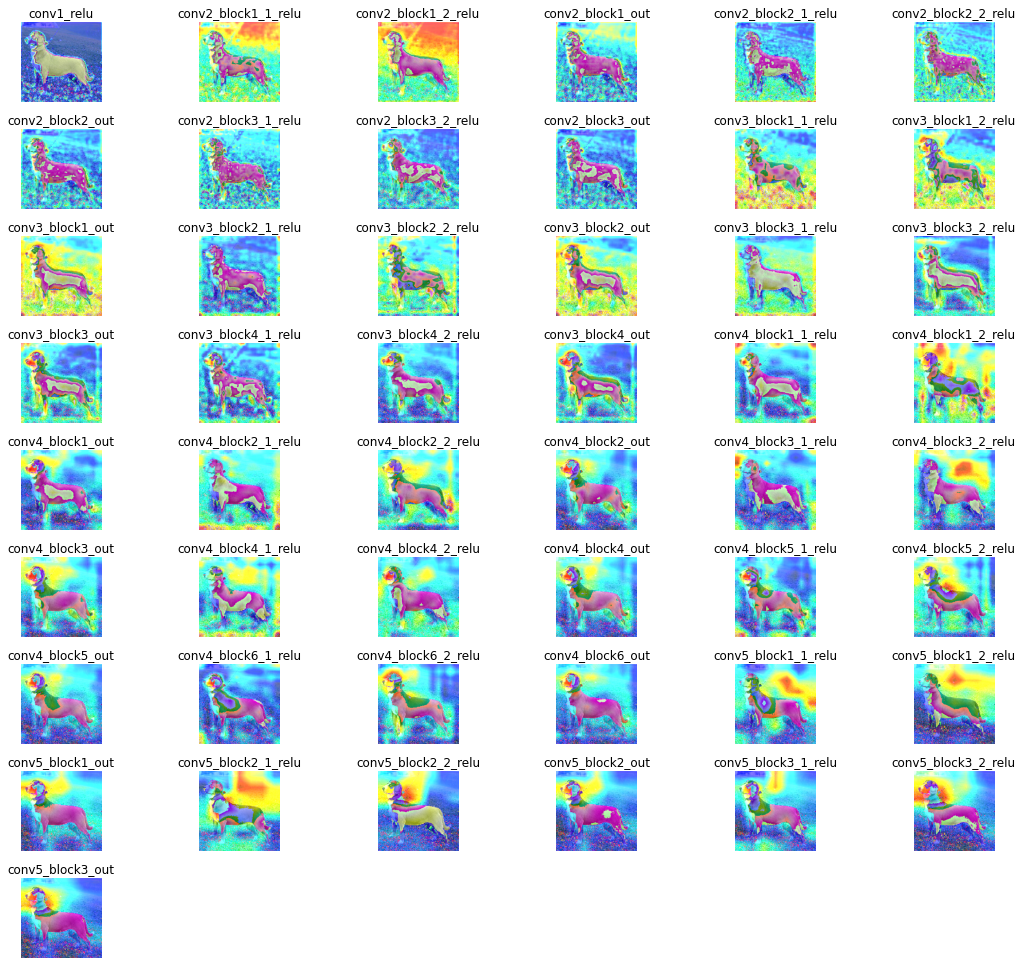

In [ ]:
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(10, 6, i + 1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()
plt.show()

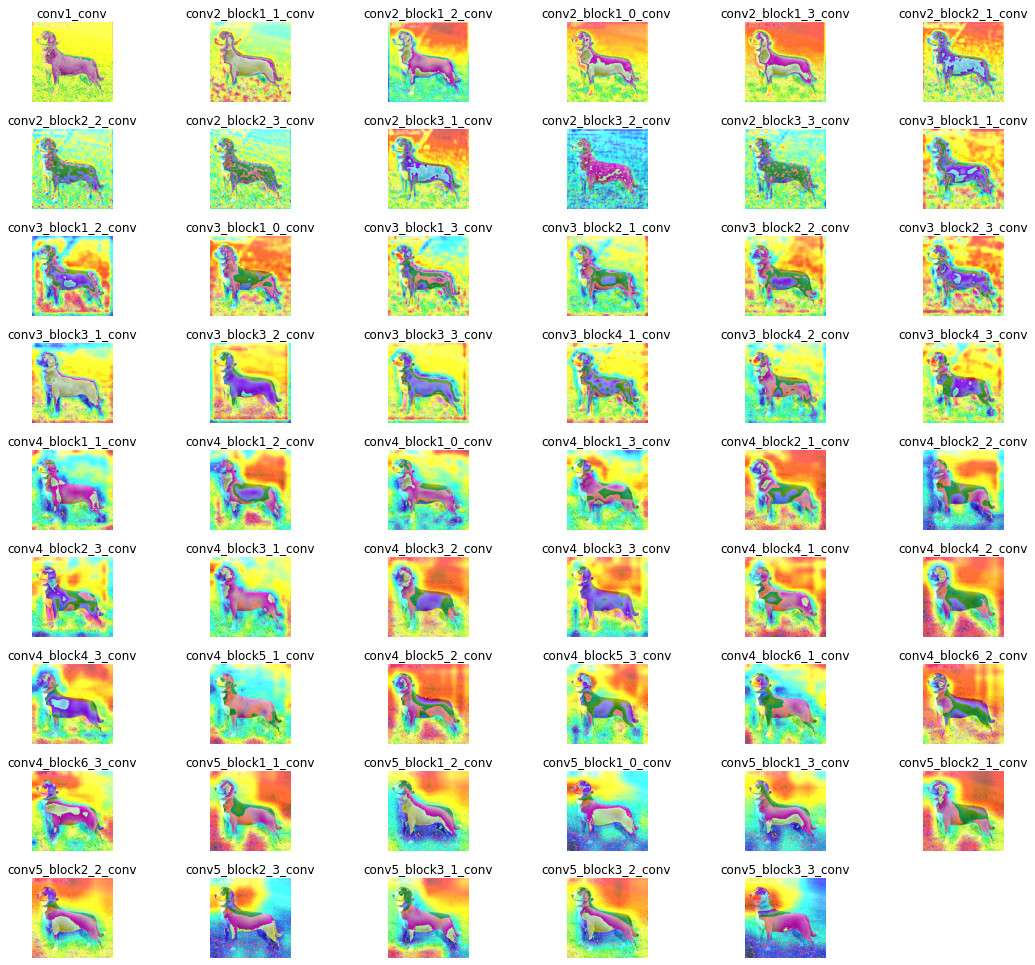

In [ ]:
plt.figure(figsize=(15, 15))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(10, 6, i + 1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

  return superimposed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


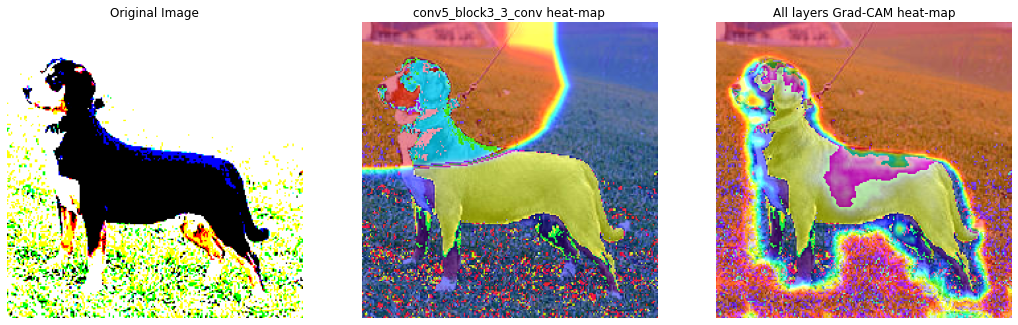

In [ ]:
fused = fuse_layers(all_layers, model, img, True)

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(f'{layer_name} heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')
plt.show()
